Epoch:0/200 Error_train: 0.5845311799866881 Error_test: 0.5788614578070684


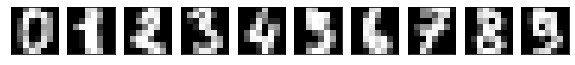

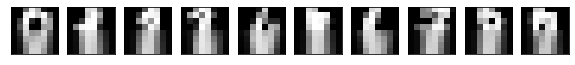

Epoch:10/200 Error_train: 0.41066477089674563 Error_test: 0.41145107250641966


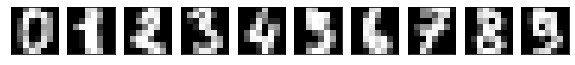

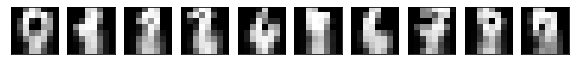

Epoch:20/200 Error_train: 0.353894278574444 Error_test: 0.3552206361025248


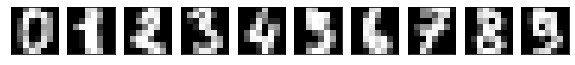

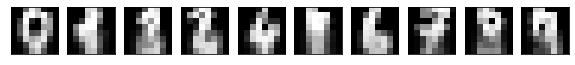

Epoch:30/200 Error_train: 0.31703338401207143 Error_test: 0.3231283072540836


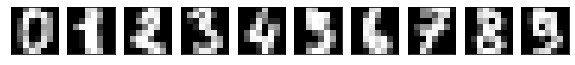

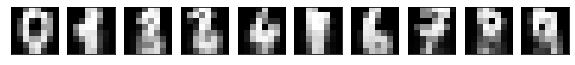

Epoch:40/200 Error_train: 0.29514352451425835 Error_test: 0.3050804375031624


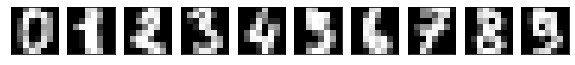

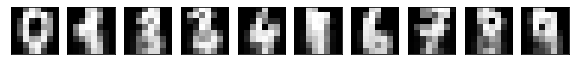

Epoch:50/200 Error_train: 0.2762612856247015 Error_test: 0.2897900797067521


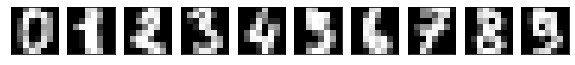

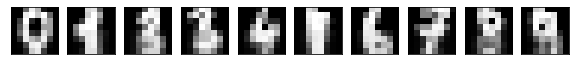

Epoch:60/200 Error_train: 0.2646987471276273 Error_test: 0.2827669825458986


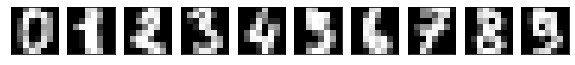

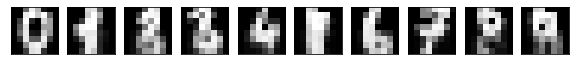

Epoch:70/200 Error_train: 0.24690653321252054 Error_test: 0.2696908993832034


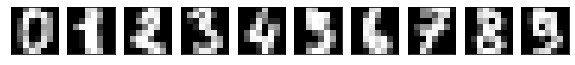

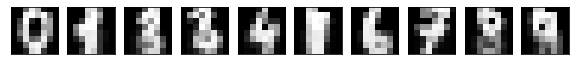

Epoch:80/200 Error_train: 0.2328637666830898 Error_test: 0.2604328661381727


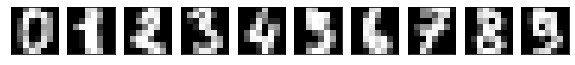

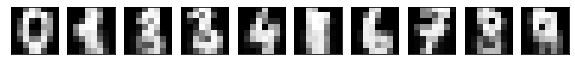

Epoch:90/200 Error_train: 0.22512264215778663 Error_test: 0.2579122805133192


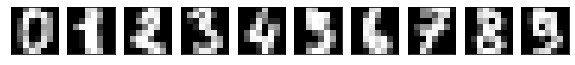

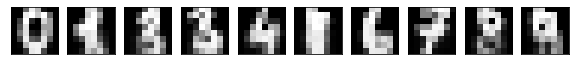

Epoch:100/200 Error_train: 0.21682435328159247 Error_test: 0.25490365262876524


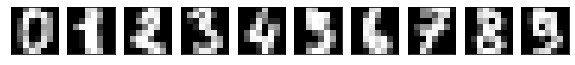

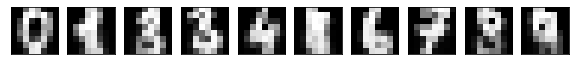

Epoch:110/200 Error_train: 0.2112383948059174 Error_test: 0.2555600534514175


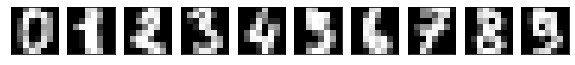

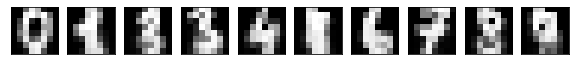

Epoch:120/200 Error_train: 0.20434968592665156 Error_test: 0.2565377561015285


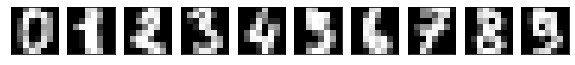

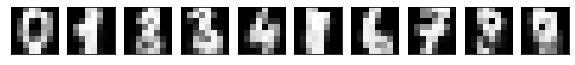

Epoch:130/200 Error_train: 0.19650724274873144 Error_test: 0.2513081253791944


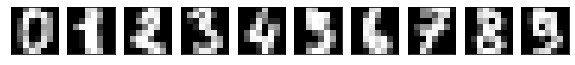

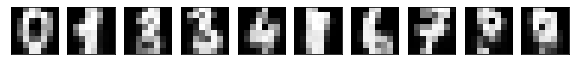

Epoch:140/200 Error_train: 0.18660706373382227 Error_test: 0.24951026076638114


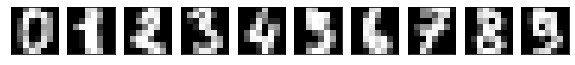

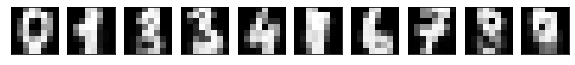

Epoch:150/200 Error_train: 0.18052005936489762 Error_test: 0.24646380998706416


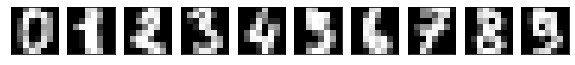

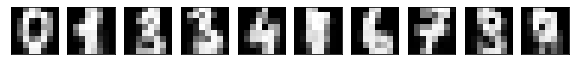

Epoch:160/200 Error_train: 0.17563316949279045 Error_test: 0.24678956252748233


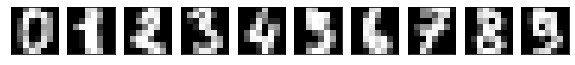

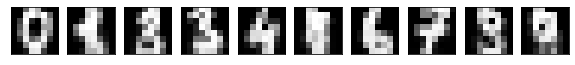

Epoch:170/200 Error_train: 0.17477171718616333 Error_test: 0.25141609408406096


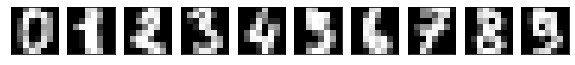

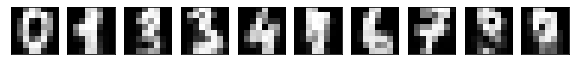

Epoch:180/200 Error_train: 0.16702453129467987 Error_test: 0.24815314359473983


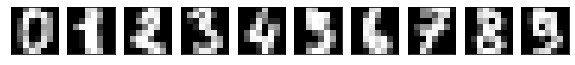

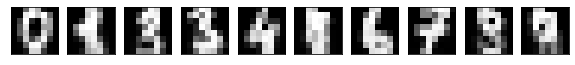

Epoch:190/200 Error_train: 0.1613770959633945 Error_test: 0.2507579005262766


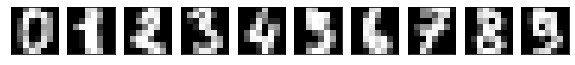

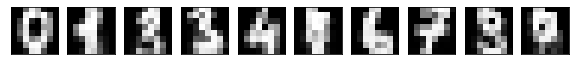

Epoch:200/200 Error_train: 0.15344144018703787 Error_test: 0.24573217874190723


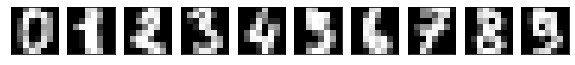

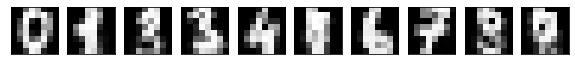

In [1]:
import numpy as np
# import cupy as np  # GPUの場合
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# -- 各設定値 --
img_size = 8  # 画像の高さと幅
n_time = 4  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 128  # 中間層のニューロン数
n_out = img_size  # 出力層のニューロン数
n_disp = 10  # 表示する画像の枚数

eta = 0.01  # 学習係数
epochs = 201
batch_size = 32
interval = 10  # 経過の表示間隔

def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- データの用意 --
digits = datasets.load_digits()
digits = np.asarray(digits.data)  # GPU対応
digits_imgs= digits.reshape(-1, img_size, img_size)
digits_imgs /= 15  # 0-1の範囲に

disp_imgs = digits_imgs[:n_disp]  # 結果の表示用
train_imgs = digits_imgs[n_disp:]  # 訓練用
n_sample_in_img = img_size-n_time  # 1枚の画像中のサンプル数
n_sample = len(train_imgs) * n_sample_in_img  # サンプル数

input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

# -- 訓練データとテストデータに分割 --
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

# -- GRU層 -- 
class GRULayer:
    def __init__(self, n_upper, n):
        # パラメータの初期値
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.v = np.random.randn(3, n, n) / np.sqrt(n)

    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))  # 更新ゲート
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))  # リセットゲート
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2]))  # 新しい記憶
        self.gates = np.stack((a0, a1, a2))

        self.y = (1-a0)*y_prev + a0*a2  # 出力
    
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates

        # 新しい記憶
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)

        # 更新ゲート
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)

        # リセットゲート
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)

        # xの勾配
        self.grad_x =  np.dot(delta_a0, self.w[0].T)
        + np.dot(delta_a1, self.w[1].T)
        + np.dot(delta_a2, self.w[2].T)

        # y_prevの勾配
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)

    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v

# -- 全結合 出力層 --
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # Xavierの初期値
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # シグモイド関数

    def backward(self, t):
        delta = (self.y-t) * self.y * (1-self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)      
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 各層の初期化 --
gru_layer = GRULayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 訓練 --
def train(x_mb, t_mb):
    # 順伝播 GRU層
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)

        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y

        gates = gru_layer.gates
        gates_rnn[:, :, i, :] = gates

    # 順伝播 出力層
    output_layer.forward(y)

    # 逆伝播 出力層
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x

    # 逆伝播 GRU層
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :] 

        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev

    # パラメータの更新
    gru_layer.update(eta)
    output_layer.update(eta)

# -- 予測 --
def predict(x_mb):
    # 順伝播 GRU層
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y

    # 順伝播 出力層
    output_layer.forward(y)
    return output_layer.y

# -- 誤差を計算 --
def get_error(x, t):
    y = predict(x)
    return np.sum(np.square(y - t)) / len(x)  # 二乗和誤差

# -- 画像を生成して表示 --
def generate_images():
    # オリジナルの画像
    plt.figure(figsize=(10, 1))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(disp_imgs[i].tolist(), cmap="Greys_r")
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成した画像
    gen_imgs = disp_imgs.copy() 
    plt.figure(figsize=(10, 1))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            gen_imgs[i, j+n_time] = predict(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(gen_imgs[i].tolist(), cmap="Greys_r")
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

n_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
for i in range(epochs):

    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        # 訓練
        train(x_mb, t_mb)
    
    # -- 経過の表示 -- 
    if i%interval == 0:
        # 誤差の計測  
        error_train = get_error(x_train, t_train)
        error_test = get_error(x_test, t_test)
        print("Epoch:" + str(i) + "/" + str(epochs-1),
              "Error_train: " + str(error_train),
              "Error_test: " + str(error_test))
        
        # 画像の生成
        generate_images()